In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#tf.enable_eager_execution()

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np

import tensorflow.keras

import os
from glob import glob

import timeit

from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import clear_output
import datetime

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
#%load_ext tensorboard

## Define the model

In [4]:
from Model import make_KaI

In [5]:
img_height = 128
img_width = 128
nclasses=2
filters=16

KaI = make_KaI(img_height, img_width, nclasses, filters)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Plot the Model

Using TensorFlow backend.


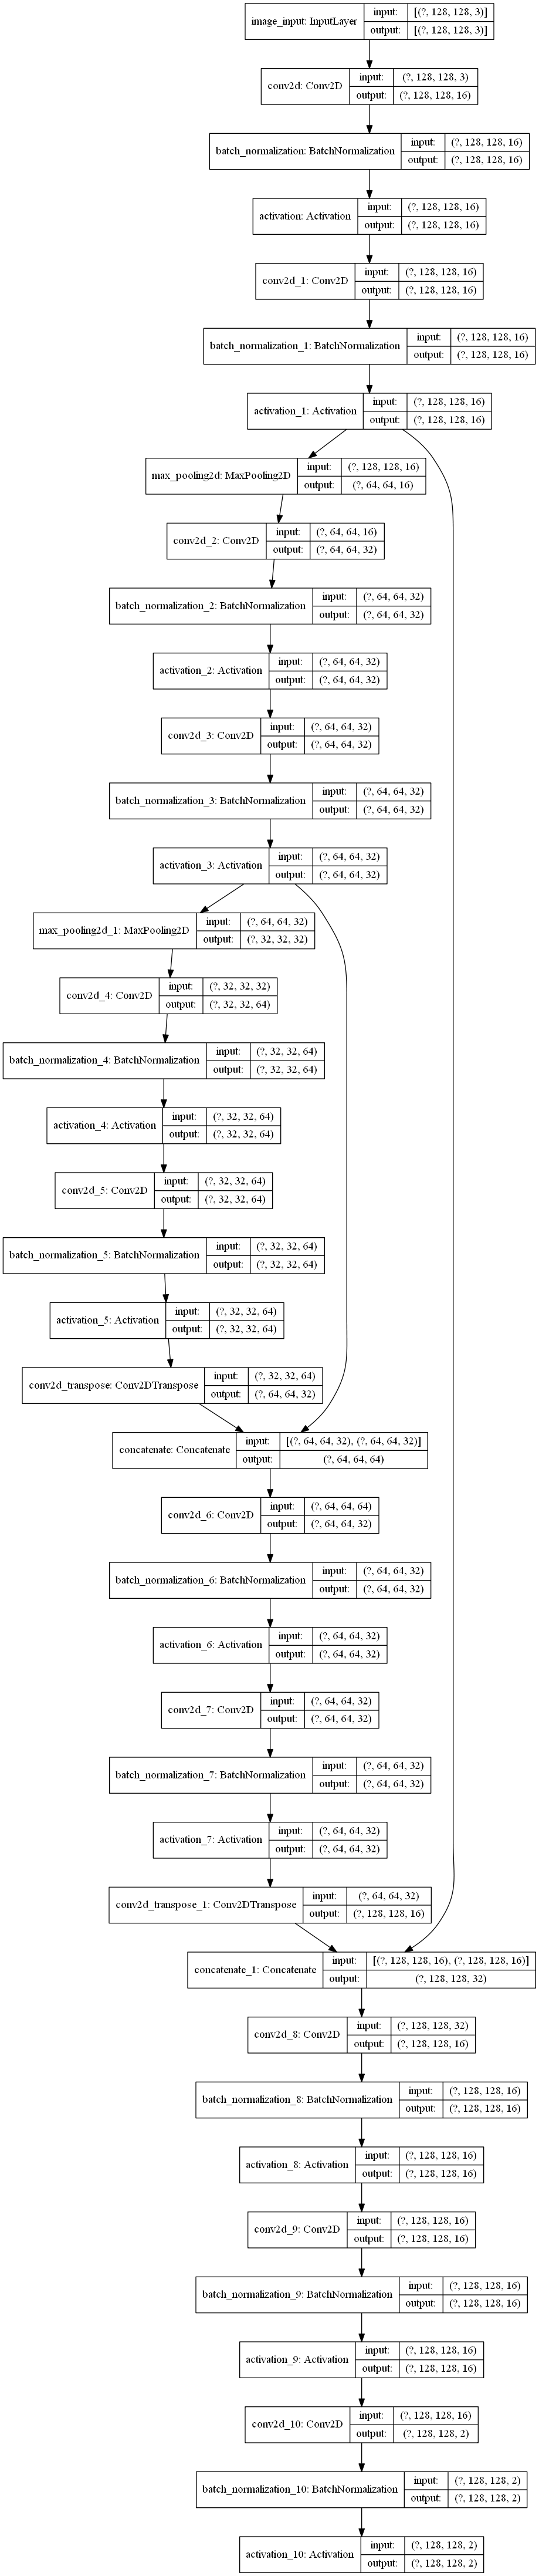

In [6]:
import pydotplus
import keras.utils
keras.utils.vis_utils.pydot = pydotplus
tf.keras.utils.plot_model(KaI, to_file="D:/Masterarbeit/Data/Randbereiche/model_full_KaI.png", show_shapes=True)

## Loading the data: Custom Generator

In [7]:
from Data import image_generator

In [8]:
files_mask_train = glob("D:\\Masterarbeit\\Data\\rescaled\\train\\WOKAM\\subfolder_wokam\\*")
files_img_train = glob("D:\\Masterarbeit\\Data\\rescaled\\train\\SRTM\\subfolder_srtm\\*")

files_mask_test = glob("D:\\Masterarbeit\\Data\\rescaled\\test\\WOKAM\\subfolder_wokam\\*")
files_img_test = glob("D:\\Masterarbeit\\Data\\rescaled\\test\\SRTM\\subfolder_srtm\\*")

In [9]:
train_generator = image_generator(files_img_train, files_mask_train, batch_size = 64, intensify = False)

In [10]:
test_generator = image_generator(files_img_test, files_mask_test, batch_size = 64, intensify = False)

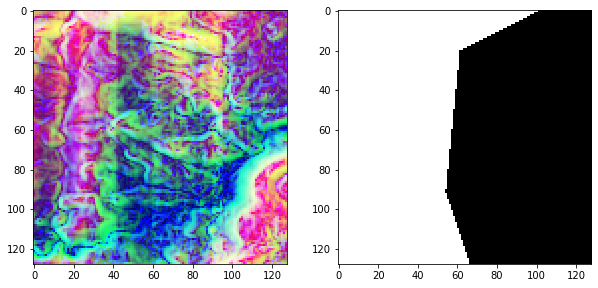

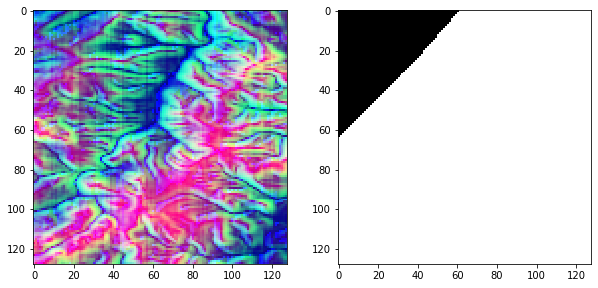

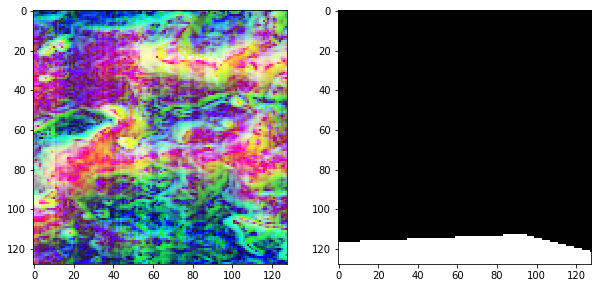

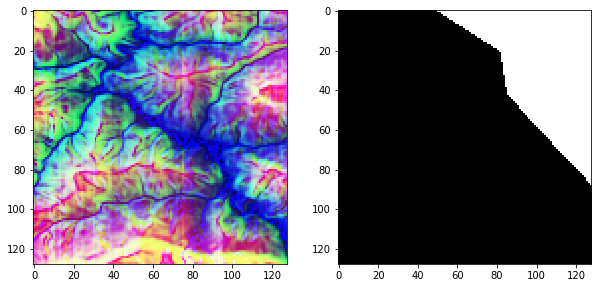

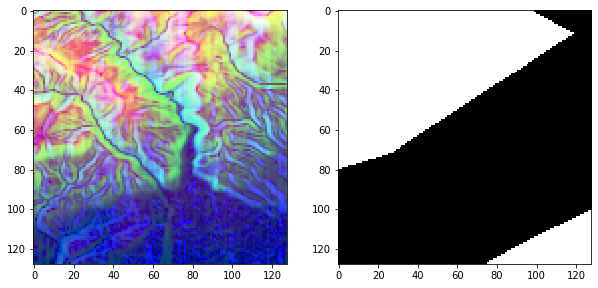

In [17]:
for i in range(0,5):
    
    x, y = next(train_generator)
    image = x[i]
    mask = y[i]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    ax1.imshow(image)
    ax2.imshow(np.argmax(mask, axis = -1), cmap = "Greys")
    
    plt.show()

## Train the Model

In [18]:
def custom_loss(y_true, y_pred):
    return tf.losses.sigmoid_cross_entropy(y_true, y_pred, label_smoothing=0.1)

In [19]:
adam = tf.keras.optimizers.Adam(lr=1e-5)
KaI.compile(optimizer=adam, loss= custom_loss , metrics=['categorical_accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
#print(unet.output_shape)
#p_unet = multi_gpu_model(unet, 4)
#p_unet.load_weights('models-dr/top_weights.h5')

tb = tf.keras.callbacks.TensorBoard(log_dir='logs', write_graph=True)
mc = tf.keras.callbacks.ModelCheckpoint(mode='max', filepath='D:/Masterarbeit/Data/rescaled/top_weights.h5', monitor='categorical_accuracy', save_best_only='True', save_weights_only='True', verbose=1)
#es = tf.keras.callbacks.EarlyStopping(mode='max', monitor='acc', patience=6, verbose=1)
#callbacks = [tb, mc, es]
callbacks = [tb, mc]

#train_gen = seg_gen(image_list, mask_list, batch_size)

history = KaI.fit_generator(
train_generator,
steps_per_epoch=len(files_mask_test) // 64,
epochs=300,
validation_data= test_generator,
validation_steps=len(files_mask_test) // 64 , callbacks=callbacks
)

Epoch 1/300
27/27 [==============================] - 34s 1s/step - loss: 0.7326 - categorical_accuracy: 0.4940

Epoch 00001: categorical_accuracy improved from -inf to 0.49892, saving model to D:/Masterarbeit/Data/rescaled/top_weights.h5
27/27 [==============================] - 151s 6s/step - loss: 0.7300 - categorical_accuracy: 0.4989 - val_loss: 0.7326 - val_categorical_accuracy: 0.4940
Epoch 2/300
27/27 [==============================] - 17s 619ms/step - loss: 0.7354 - categorical_accuracy: 0.4822

Epoch 00002: categorical_accuracy did not improve from 0.49892
27/27 [==============================] - 91s 3s/step - loss: 0.7311 - categorical_accuracy: 0.4942 - val_loss: 0.7354 - val_categorical_accuracy: 0.4822
Epoch 3/300
27/27 [==============================] - 20s 744ms/step - loss: 0.7346 - categorical_accuracy: 0.4890

Epoch 00003: categorical_accuracy did not improve from 0.49892
27/27 [==============================] - 184s 7s/step - loss: 0.7308 - categorical_accuracy: 0.4957

KeyboardInterrupt: 

## Show training history

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
with PdfPages("C:/Users/Veigel/Pictures/Memos/training_loss_200412.pdf") as pdf:
# Plot training & validation accuracy values
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(history.history['categorical_accuracy'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='upper left')
    fig.show()
        
        # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'], loc='upper left')
    fig.show()
    pdf.savefig(fig)

## Show predictions

In [ ]:
predictions = KaI.predict(test_generator, steps = len(files_mask_test) // 64 )

In [ ]:
preds = np.argmax(predictions, axis=-1)
#print(preds_reshape.shape)
print(predictions.shape)
#print(preds_reshape[19,:,:,0])
print(predictions[19,:,:,0])
print(preds.shape)

In [ ]:
plt.imshow(preds[19,:,:])